<h1> Brain Tumor Classification (EfficientNet) </h1>

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [65]:
import tensorflow as tf
from tensorflow import keras

In [66]:
import random

In [67]:
np.random.seed(1)
tf.random.set_seed(1)

<h3> Split Data </h3>

In [68]:
train_folder = 'D:\\MRI BrainTumor\\Training' 
test_folder = 'D:\\MRI BrainTumor\\Testing'

In [69]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    validation_split= 0.2,
    subset= 'training',
    shuffle = True,
    seed = 1
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [70]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    shuffle = True,
    seed = 1
)
    


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [71]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    shuffle = False,
    seed = 1
)

Found 1311 files belonging to 4 classes.


In [72]:
train_class_names = train_dataset.class_names
val_class_names = val_dataset.class_names
test_class_names = test_dataset.class_names

<h3> Data Visualization </h3>

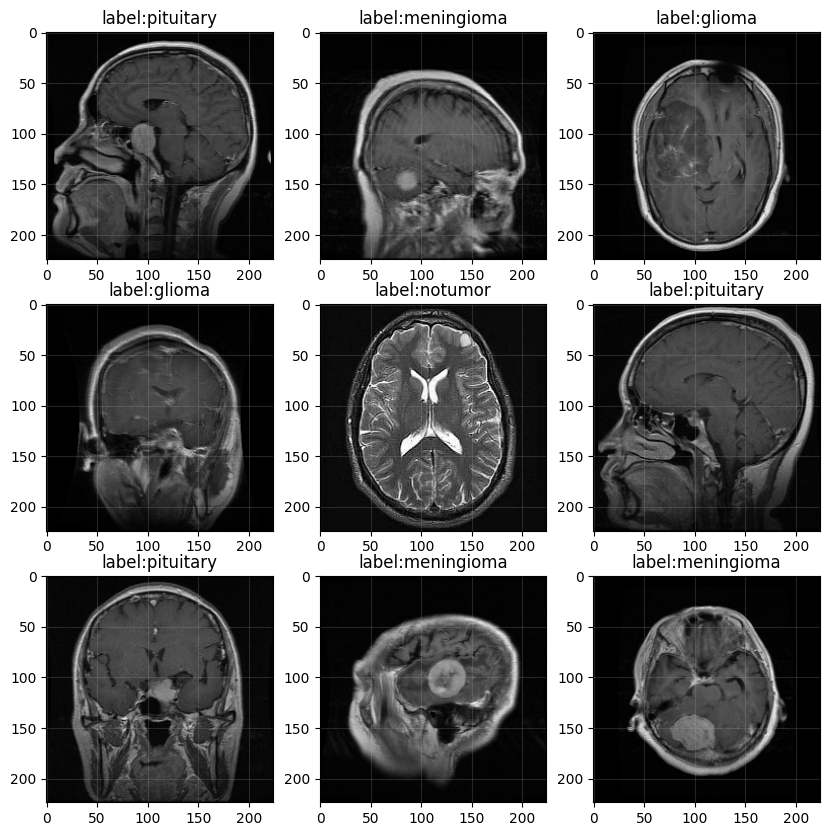

In [73]:
#display dataset
def display_dataset (dataset, class_names, num_images = 9):
    plt.figure(figsize = (10,10))
    for i, (image,label) in enumerate (dataset.take(1)):
        for j in range (num_images):
            plt.subplot(3,3,j+1)
            plt.imshow(image[j].numpy().astype('uint8'))
            label_name = class_names[label [j].numpy()]
            plt.title(f"label:{label_name}")
            plt.axis("on")
            plt.grid(alpha =0.2)
        plt.show()
        break
display_dataset(train_dataset, train_class_names)


<h3> Data Preprocessing </h3>

In [74]:
#data augmentation:
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomTranslation, RandomBrightness, RandomContrast, GaussianNoise

In [75]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('vertical'),
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.3),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomBrightness(factor = 0.0009),
    RandomContrast(0.0009),
    GaussianNoise(0.1)
])

In [76]:
#preprocessing
def preprocess (image, label, training = True):
    if training:
        image = data_augmentation(image)
    image = tf.image.resize(image, (224,224))
    image = image/225
    return image, label
    
train_dataset_aug = train_dataset.map(lambda x,y:preprocess(x,y,training = True))
val_dataset_aug = val_dataset.map(lambda x,y:preprocess(x,y,training = False))
test_dataset_aug = test_dataset.map(lambda x,y:preprocess(x,y,training = True))   

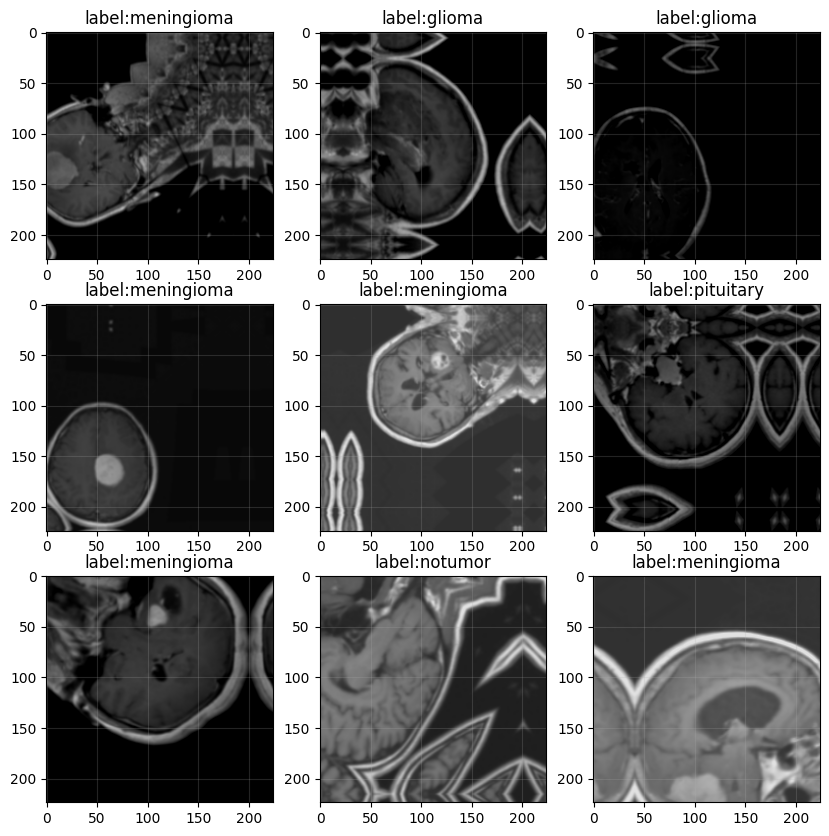

In [77]:
#display augmented data
def display_augmentaed_images (dataset,class_names,num_images = 9):
    plt.figure(figsize=(10,10))
    for i, (image, label) in enumerate (dataset.take(1)):
        for j in range(num_images):
            augmented_image = data_augmentation(image[j:j+1])
            augmented_image = augmented_image[0]*225
            augmented_image = tf.clip_by_value(augmented_image,0,225)
            plt.subplot(3,3,j+1)
            plt.imshow(augmented_image.numpy().astype('uint8'))
            label_name = class_names[label[j].numpy()]
            plt.title(f"label:{label_name}")
            plt.axis('on')
            plt.grid(alpha = 0.2)
        plt.show()
display_augmentaed_images(train_dataset_aug, train_class_names)
            

<h3> Model Building </h3>

In [78]:
#build model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

In [79]:
#for transfer learning
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [80]:
base_model_efficient = EfficientNetB0(
    include_top = False,
    weights= 'imagenet',
    input_shape = (224,224,3)
)

<h2> Fine-Tuning </h2>

In [81]:
#freeze the 20 middle layers
for layer in base_model_efficient.layers[:20]:
    layer.trainable = False
for layer in base_model_efficient.layers[20:40]:
    layer.trainable = True
for layer in base_model_efficient.layers[40:]:
    layer.trainable  = False

In [82]:
model = Sequential([
    base_model_efficient,
    GlobalAveragePooling2D(),

    Dense(256, activation = 'relu',kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(train_class_names), activation = 'softmax')
])
    

In [83]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 339,080 (1.29 MB)

 Non-trainable params: 4,040,479 (15.41 MB)

In [84]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [85]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 6,
    restore_best_weights= True
)

In [86]:
lr_scheduler = ReduceLROnPlateau(
    monitor= 'val_loss',
    factor = 0.5,
    patience = 6,
    verbose = 1,
    min_lr = 1e-6
)
    

In [87]:
#compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
             )

In [89]:
#train model
history = model.fit(
    train_dataset_aug,
    validation_data = val_dataset_aug,
    epochs = 100,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4060 - loss: 2.0626 - val_accuracy: 0.2277 - val_loss: 2.0928 - learning_rate: 1.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5559 - loss: 1.5836 - val_accuracy: 0.2636 - val_loss: 2.7815 - learning_rate: 1.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.5998 - loss: 1.4585 - val_accuracy: 0.3818 - val_loss: 2.1141 - learning_rate: 1.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6256 - loss: 1.3884 - val_accuracy: 0.5709 - val_loss: 1.3691 - learning_rate: 1.0000e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6627 - loss: 1.2973 - val_accuracy: 0.6445 - val_loss: 1.2699 - learning_rate: 1.0000e-04
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6872 - loss: 1.2098 - val_accuracy: 0.5385 - val_loss: 1.4973 - learning_rate: 1.0000e-04
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/ste

<h2> Test Accuracy and Loss </h2>

In [90]:
test_loss, test_accuracy = model.evaluate(test_dataset_aug)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - accuracy: 0.7818 - loss: 0.8946
Test Loss: 0.8522
Test Accuracy: 0.8024


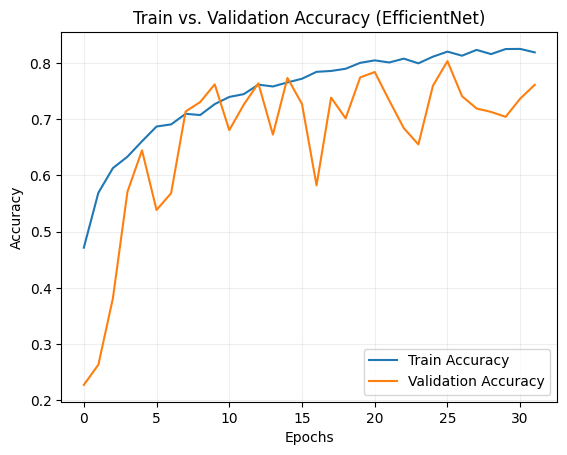

In [91]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Accuracy (EfficientNet)")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('EfficientNetB0 accuracy last 37 layers unfrozen.png')
plt.show()


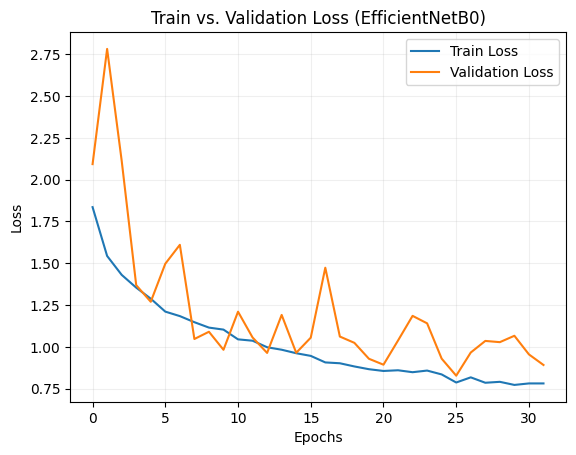

In [92]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Loss (EfficientNetB0)")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('EfficientNetB0 loss last 37 layer unfrozen.png')
plt.show()


<h2> Confusion Matrix </h2>

In [93]:
# Generate predictions
y_pred_probs = model.predict(test_dataset_aug)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)


41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 584ms/step


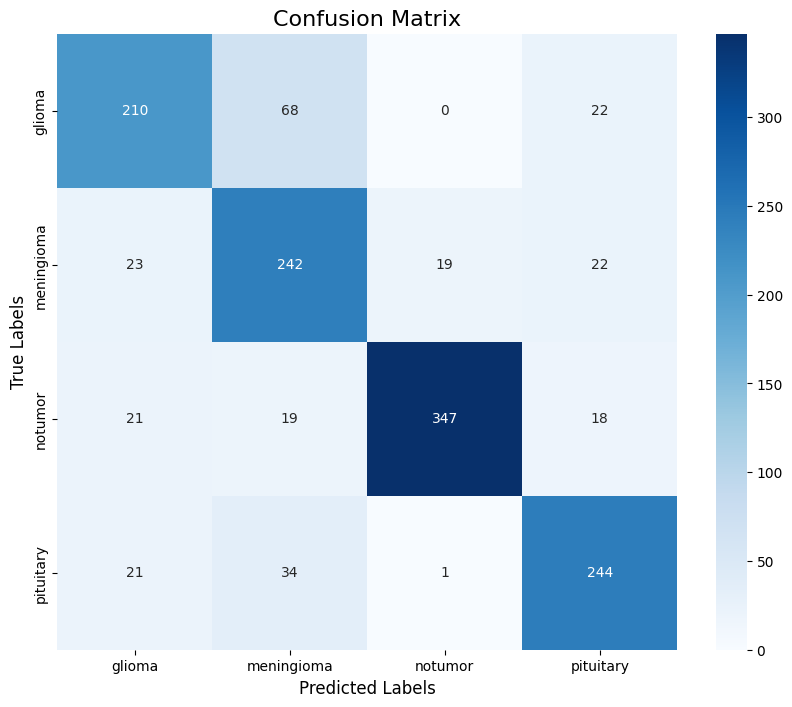

In [94]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_names, yticklabels=test_class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.savefig('Confusion Matrix (EfficientNetB0 last 37 layer unfrozen)')
plt.show()


<h2> Model Evaluation </h2>

In [97]:
# Extract training history
history_data = history.history  # Access the history attribute

# Compute the mean and standard deviation for loss
train_loss = history_data['loss']
val_loss = history_data['val_loss']

train_loss_mean = np.mean(train_loss)
train_loss_std = np.std(train_loss)
val_loss_mean = np.mean(val_loss)
val_loss_std = np.std(val_loss)

# Compute the confidence interval (95%) for loss
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)  # Standard Error
    h = se * 1.96  # t-value for 95% CI
    return mean - h, mean + h

# Confidence interval for training and validation loss
train_loss_ci = confidence_interval(train_loss)
val_loss_ci = confidence_interval(val_loss)

print(f"Train Loss - Mean: {train_loss_mean:.4f}, Std: {train_loss_std:.4f}, 95% CI: {train_loss_ci}")
print(f"Validation Loss - Mean: {val_loss_mean:.4f}, Std: {val_loss_std:.4f}, 95% CI: {val_loss_ci}")

# Compute the mean and standard deviation for accuracy
train_accuracy = history_data['accuracy']
val_accuracy = history_data['val_accuracy']

train_acc_mean = np.mean(train_accuracy)
train_acc_std = np.std(train_accuracy)
val_acc_mean = np.mean(val_accuracy)
val_acc_std = np.std(val_accuracy)

# Compute the confidence interval (95%) for accuracy
train_acc_ci = confidence_interval(train_accuracy)
val_acc_ci = confidence_interval(val_accuracy)

print(f"Train Accuracy - Mean: {train_acc_mean:.4f}, Std: {train_acc_std:.4f}, 95% CI: {train_acc_ci}")
print(f"Validation Accuracy - Mean: {val_acc_mean:.4f}, Std: {val_acc_std:.4f}, 95% CI: {val_acc_ci}")

Train Loss - Mean: 1.0165, Std: 0.2491, 95% CI: (0.9301508889386639, 1.1027899309208409)
Validation Loss - Mean: 1.2109, Std: 0.4135, 95% CI: (1.067680992262138, 1.3542161657645573)
Train Accuracy - Mean: 0.7478, Std: 0.0827, 95% CI: (0.7191285559492333, 0.7764266921622531)
Validation Accuracy - Mean: 0.6666, Std: 0.1383, 95% CI: (0.6186910233232829, 0.7144963761087803)


<h2> Classification Report </h2>

In [98]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# Predicting on the training data
train_true_labels = []
train_pred_labels = []

for images, labels in train_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    train_true_labels.extend(labels.numpy())  # True labels
    train_pred_labels.extend(predicted_labels)  # Predicted labels

# Predicting on the validation data
val_true_labels = []
val_pred_labels = []

for images, labels in val_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    val_true_labels.extend(labels.numpy())  # True labels
    val_pred_labels.extend(predicted_labels)  # Predicted labels

# Calculate F1 score for training data
train_f1_score = f1_score(train_true_labels, train_pred_labels, average='weighted')  # Use 'weighted' for class imbalance
# Calculate F1 score for validation data
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='weighted')  # Use 'weighted' for class imbalance

print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")

# You can also print a full classification report with precision, recall, and F1 for each class
print("\nClassification Report for Training Data:")
print(classification_report(train_true_labels, train_pred_labels, target_names=train_class_names))

print("\nClassification Report for Validation Data:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<h2> ROC AUC Curve </h2>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

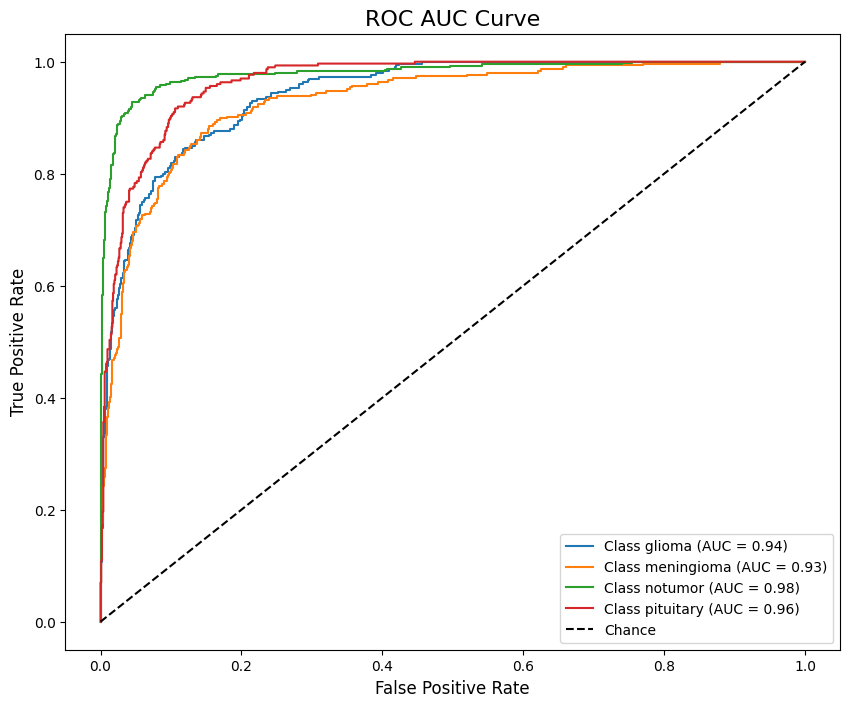

In [99]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
y_true = []
y_pred_proba = []

for images, labels in test_dataset_aug:
    y_true.extend(labels.numpy())
    y_pred_proba.extend(model.predict(images))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=range(len(test_class_names)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels and legend
plt.title('ROC AUC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid
plt.savefig('ROC AUC Curve (EfficientNet last 37 layers unfrozen-30 layers)')
plt.show()


<h2> Prediction of Unseen Image </h2>

In [95]:
from tensorflow.keras.preprocessing import image


# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load image in grayscale mode and resize
    img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
    
    # Convert image to numpy array and expand dimensions to match model input shape
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    
    # Normalize image values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Function to predict the class of the image
def predict_image(model, img_array, class_names):
    # Get model predictions (probabilities)
    predictions = model.predict(img_array)
    
    # Get the predicted class label (index of the highest probability)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_idx]
    
    return predicted_class_name, predictions[0][predicted_class_idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: glioma
Prediction Probability: 0.9381


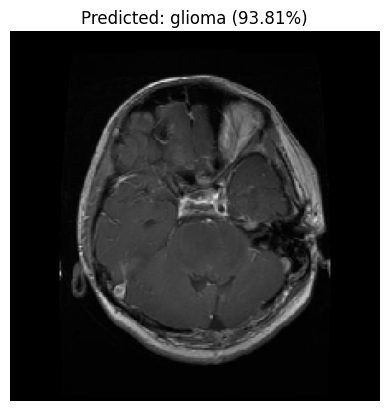

In [96]:
# Load and preprocess the image
img_path = 'D:\\Datasets\\new data\\gg.jpg'  # Provide the path to the MRI image
processed_image = load_and_preprocess_image(img_path)

# Predict the class
predicted_class_name, predicted_prob = predict_image(model, processed_image, test_class_names)

# Display the result
print(f"Predicted Class: {predicted_class_name}")
print(f"Prediction Probability: {predicted_prob:.4f}")

# Display the image and prediction
plt.imshow(processed_image[0].squeeze())  # Use cmap="gray" for grayscale images
plt.title(f"Predicted: {predicted_class_name} ({predicted_prob*100:.2f}%)")
plt.axis('off')
plt.show()
